In [146]:
from scipy.io import wavfile
import numpy as np
import os
import matplotlib.pyplot as plt
import struct
import pandas as pd
import plotly.express as px
import scipy as sp
import json
from sklearn.linear_model import LinearRegression

In [2]:
data_dir = '../data'

raw_dir = 'raw'

processed_dir = 'processed'

recordings_folder = 'wav1'

In [3]:
def file_path_raw(name):
    name = name.upper() + '.DAT'
    return os.path.join(data_dir, raw_dir, recordings_folder, name)

def file_path_processed(name):
    name = name.upper() + '.csv'
    return os.path.join(data_dir, processed_dir, name)

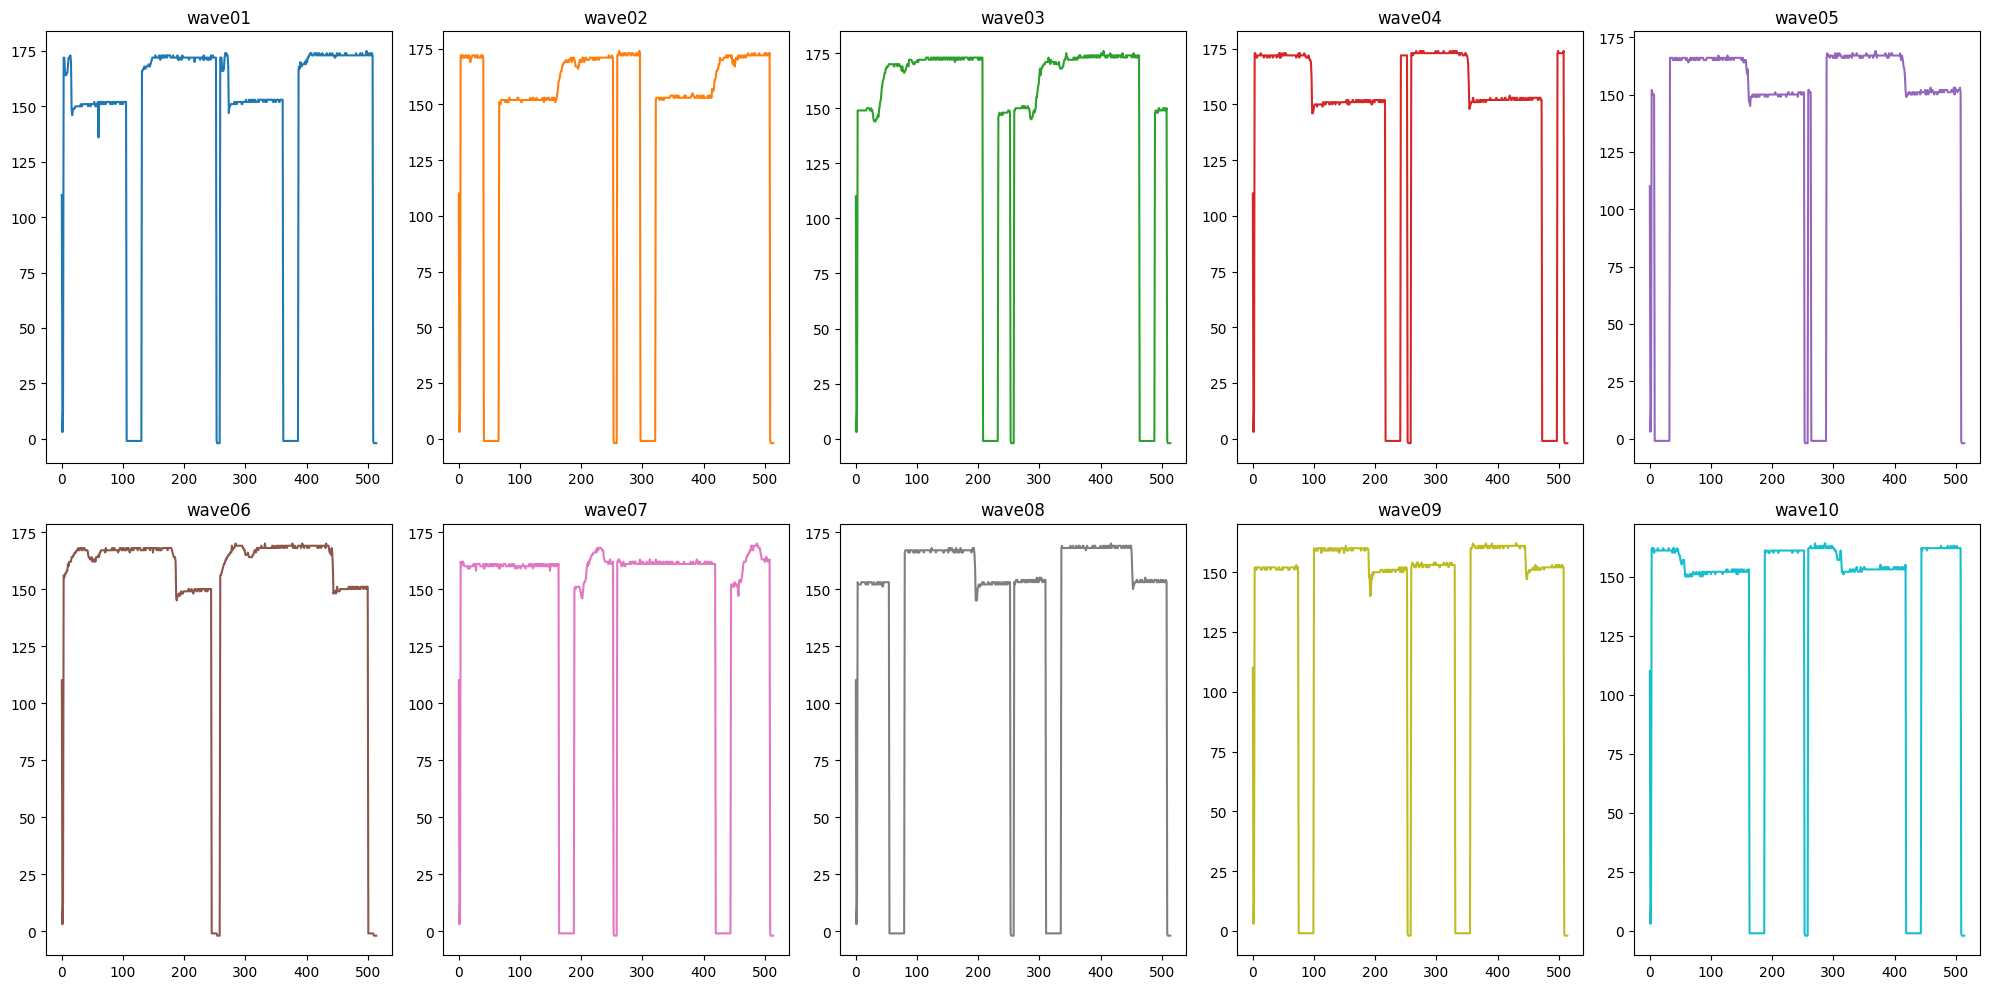

In [4]:
# READ FILES AND PLOT SIGNALS

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    file_name = f'wave{i+1:02d}'
    with open(file_path_raw(file_name), 'rb') as file:
        data = file.read()
        header = struct.unpack('d', data[:8])
        signal = struct.unpack(f'{(len(data)-8)//2}h', data[8:])
        axes[i].set_title(file_name)
        axes[i].plot(signal, color=colors[i])
        np.savetxt(file_path_processed(file_name), signal, delimiter=',')

plt.tight_layout()
plt.show()

In [134]:
file_test = 'wave06'
signal = np.fromfile(file_path_raw(file_test), dtype=np.int16, offset=8)

In [135]:
# TODO DAC conversion (what do the values mean????)
resolution = 8
Vref = 5
def DAC(signal, resolution, Vref):
    return signal * (Vref / 2**resolution)

signal_V = DAC(signal, resolution, Vref)

In [136]:
window = 5
window_avg = 10
scale_fac = 1000

moving_average = np.convolve(signal_V, np.ones(window)/window, mode='valid')

poly_order = 1
filtered_signal = sp.signal.savgol_filter(signal_V, window, poly_order) # NOTE: Savitzky-Golay filter decreases noise without the artifacts that a Butterworth low-pass filter did

derivative = np.diff(signal_V, n=2)
derivative_fromfiltered = np.diff(filtered_signal, n=2)
average_rate_of_change = np.convolve(filtered_signal, np.concatenate([np.array([-1]), np.zeros((window_avg-2)), np.array([1])])/window_avg, mode='valid')
average_2nd_derivative = np.convolve(average_rate_of_change , np.concatenate([np.array([-1]), np.zeros((window_avg-2)), np.array([1])])/window_avg, mode='valid')

min_length = min(len(signal_V), len(moving_average), len(derivative), len(derivative_fromfiltered), len(filtered_signal), len(average_rate_of_change), len(average_2nd_derivative))

df = pd.DataFrame({
    'signal_V': signal_V[:min_length],
    #'derivative': derivative[:min_length],
    #'derivative_fromfiltered': derivative_fromfiltered[:min_length],   ---> NOTE: this looks way more noisy than the derivative, why?
    'savgol': filtered_signal[:min_length],
    'avg_dfdx': average_rate_of_change[:min_length],
    'avg_d2fdx2': average_2nd_derivative[:min_length],
})


After testing quite a lot of options, the best way to capture variation in this data is with an average rate of change. To detect where the curve isn't flat, we took the 2nd average rate of change and thresholded it.

In [137]:
fig = px.line(df, title='Signal Data')
fig.show()

In [138]:
stable_signal = df['savgol'][np.abs(df['avg_d2fdx2']) < 0.0001]
px.line(stable_signal, title='Stable Signal Data')

In [123]:
with open(os.path.join(data_dir, 'meta.json'), 'r') as file:
    meta_dict = json.load(file)

print(meta_dict)

{'01': {'mass': 463, 'prototype': 'R', 'prototype_id': 1}, '02': {'mass': 426, 'prototype': 'R', 'prototype_id': 1}, '03': {'mass': 385, 'prototype': 'R', 'prototype_id': 1}, '04': {'mass': 336, 'prototype': 'R', 'prototype_id': 1}, '05': {'mass': 288, 'prototype': 'R', 'prototype_id': 1}, '06': {'mass': 213, 'prototype': 'R', 'prototype_id': 1}, '07': {'mass': 186, 'prototype': 'R', 'prototype_id': 1}, '08': {'mass': 160, 'prototype': 'R', 'prototype_id': 1}, '09': {'mass': 106, 'prototype': 'R', 'prototype_id': 1}, '10': {'mass': 75, 'prototype': 'R', 'prototype_id': 1}, '11': {'mass': 46, 'prototype': 'R', 'prototype_id': 1}, '12': {'mass': 1558, 'prototype': 'R', 'prototype_id': 1}, '13': {'mass': 1436, 'prototype': 'R', 'prototype_id': 1}, '14': {'mass': 1200, 'prototype': 'R', 'prototype_id': 1}, '15': {'mass': 1074, 'prototype': 'R', 'prototype_id': 1}, '16': {'mass': 859, 'prototype': 'R', 'prototype_id': 1}, '17': {'mass': 745, 'prototype': 'R', 'prototype_id': 1}, '18': {'mas

In [116]:
block_area = 28e-4

In [147]:
weights = np.array([])
vmaxs = np.array([])
vmins = np.array([])
for i in range(10):
    file_ID = f'{i+1:02d}'
    file_name = f'wave{file_ID}'
    signal = np.fromfile(file_path_raw(file_name), dtype=np.int16, offset=8)
    signal_V = DAC(signal, resolution, Vref)
    savgoled = sp.signal.savgol_filter(signal_V, window, poly_order)
    avg_rate_of_change = np.convolve(savgoled, np.concatenate([np.array([-1]), np.zeros((window_avg-2)), np.array([1])])/window_avg, mode='valid')
    avg_2nd_derivative = np.convolve(avg_rate_of_change , np.concatenate([np.array([-1]), np.zeros((window_avg-2)), np.array([1])])/window_avg, mode='valid')
    stable_signal = savgoled[:len(avg_2nd_derivative)][np.abs(avg_2nd_derivative) < 0.0001]
    print('Weight = ', meta_dict[file_ID]['mass'])
    weights = np.append(weights, meta_dict[file_ID]['mass'])
    print('Vmax = ', max(stable_signal))
    vmaxs = np.append(vmaxs, max(stable_signal))
    print('Vmin = ', min(stable_signal))
    vmins = np.append(vmins, min(stable_signal))

pressure = weights/block_area *1e-3 # kPa

df = pd.DataFrame({
    'Pressure': pressure,
    'Vmax': vmaxs,
    'Vmin': vmins
})

fig = px.scatter(df, x='Pressure', y='Vmax', title='Pressure (kPa) vs Vmax')
# Fit a line to the data

X = df[['Pressure']].values
y = df['Vmax'].values

model = LinearRegression()
model.fit(X, y)

# Predict values
df['Vmax_pred'] = model.predict(X)

# Plot the data and the fitted line
fig = px.scatter(df, x='Pressure', y='Vmax', title='Pressure (kPa) vs Vmax')
fig.add_traces(px.line(df, x='Pressure', y='Vmax_pred').data)
fig.show()




Weight =  463
Vmax =  3.390624999999999
Vmin =  -0.019531249999999993
Weight =  426
Vmax =  3.374999999999999
Vmin =  -0.019531249999999993
Weight =  385
Vmax =  3.410156249999999
Vmin =  -0.019531249999999993
Weight =  336
Vmax =  3.390624999999999
Vmin =  -0.019531249999999993
Weight =  288
Vmax =  3.273437499999999
Vmin =  -0.019531249999999993
Weight =  213
Vmax =  3.300781249999999
Vmin =  2.906249999999999
Weight =  186
Vmax =  3.300781249999999
Vmin =  -0.019531249999999993
Weight =  160
Vmax =  3.300781249999999
Vmin =  -0.019531249999999993
Weight =  106
Vmax =  3.148437499999999
Vmin =  -0.019531249999999993
Weight =  75
Vmax =  3.179687499999999
Vmin =  -0.019531249999999993
